# Explore here

In [1]:
# Your code here
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Elegimos donde estará el dataset
base_dir = 'dataset'

#Donde iran
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#Creamos los directorios tanto de gatos del entrenamiento como del test
os.makedirs(os.path.join(train_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'cats'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'cats'), exist_ok=True)


2025-05-14 08:11:38.940486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 08:11:38.940627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 08:11:39.073781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:


# Movemos los archivos 80% al train y 20% al test 
image_files = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
total_images = len(image_files)
train_count = int(0.8 * total_images)

for i, fname in enumerate(image_files):
    label = 'dogs' if 'dog' in fname else 'cats'
    src = os.path.join(train_dir, fname)
    if i < train_count:
        dst = os.path.join(train_dir, label, fname)
    else:
        dst = os.path.join(test_dir, label, fname)
    shutil.move(src, dst)


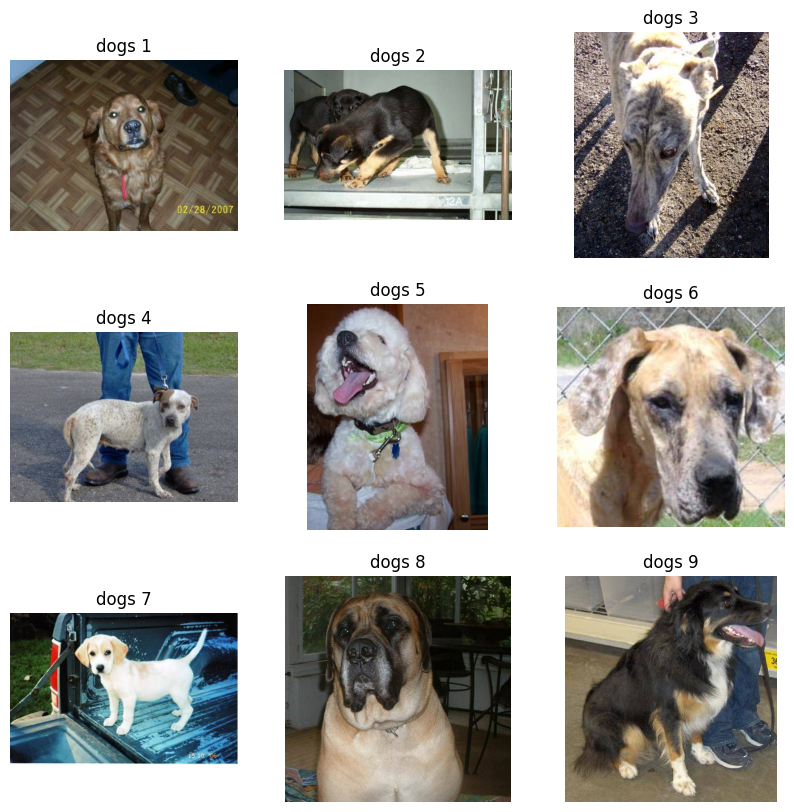

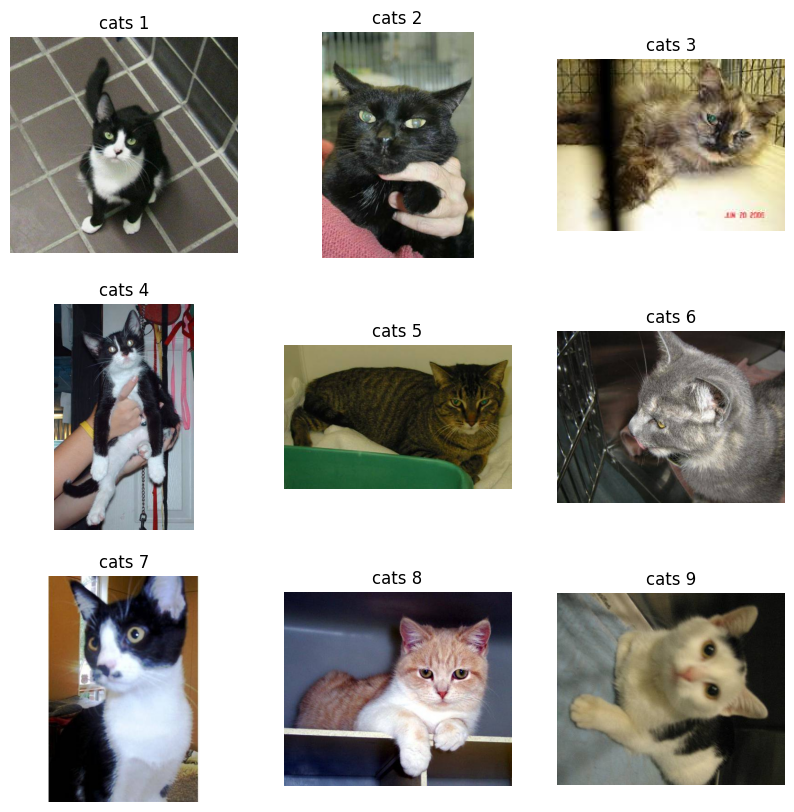

In [3]:

# Creamos un archivo para ver 9 fotos de gatos y 9 fotos de perros
def plot_images(label, num_images=9):
    label_dir = os.path.join(train_dir, label)
    image_files = [f for f in os.listdir(label_dir) if f.endswith('.jpg')][:num_images]
    
    plt.figure(figsize=(10, 10))
    for i, fname in enumerate(image_files):
        img_path = os.path.join(label_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f'{label} {i+1}')
        plt.axis('off')
    plt.savefig(f'{label}_ejemplos.png')

plot_images('dogs')
plot_images('cats')


In [4]:

#Creamos el generador de imagenes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

trdata = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=8,
    class_mode='binary'
)

tsdata = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=8,
    class_mode='binary'
)

print("Los indices:", trdata.class_indices)


Found 19999 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.
Los indices: {'cats': 0, 'dogs': 1}


In [5]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding="same"))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPool2D((2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:

# Lo compilamos
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [7]:

# Entrenamos y mejoramos el modelo
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    trdata,
    epochs=20,
    validation_data=tsdata,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


Epoch 1/20
2500/2500 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.5667
Epoch 1: val_accuracy improved from -inf to 0.62787, saving model to best_model.keras
2500/2500 [==============================] - 629s 250ms/step - loss: 0.6716 - accuracy: 0.5667 - val_loss: 0.6460 - val_accuracy: 0.6279
Epoch 2/20
2500/2500 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.6325
Epoch 2: val_accuracy improved from 0.62787 to 0.69126, saving model to best_model.keras
2500/2500 [==============================] - 553s 221ms/step - loss: 0.6351 - accuracy: 0.6325 - val_loss: 0.5858 - val_accuracy: 0.6913
Epoch 3/20
2500/2500 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.6877
Epoch 3: val_accuracy improved from 0.69126 to 0.69846, saving model to best_model.keras
2500/2500 [==============================] - 555s 222ms/step - loss: 0.5890 - accuracy: 0.6877 - val_loss: 0.5701 - val_accuracy: 0.6985
Epoch 4/20
2500/2500 [=========

626/626 [==============================] - 41s 66ms/step - loss: 0.3668 - accuracy: 0.8380
Perdida: 0.3668198585510254
Precisión: 0.8380323648452759


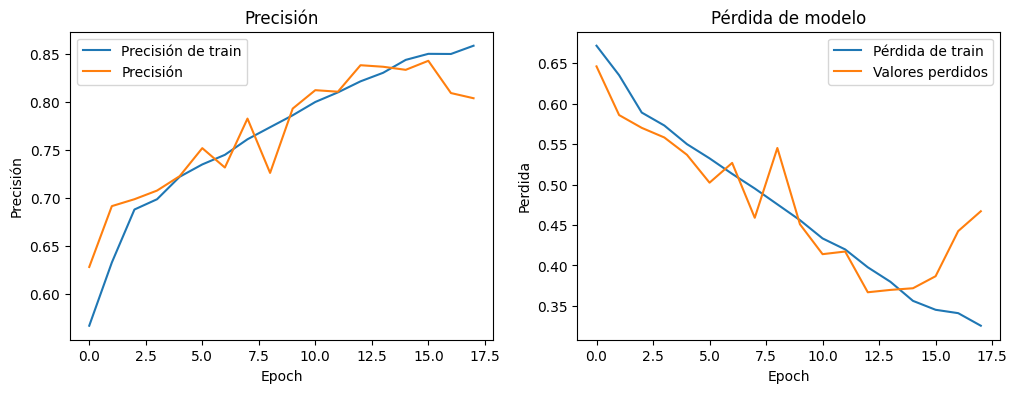

In [10]:

# Lo evaluamos
#He tenido que cambiar parametros o me explotaba y aún así ha tardado mucho
test_loss, test_accuracy = model.evaluate(tsdata, verbose=1)
print(f"Perdida: {test_loss}")
print(f"Precisión: {test_accuracy}")

# entrenamiento recorrido
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de train')
plt.plot(history.history['val_accuracy'], label='Precisión')
plt.title('Precisión')
plt.xlabel('Epoch')
plt.ylabel('Precisión')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de train')
plt.plot(history.history['val_loss'], label='Valores perdidos')
plt.title('Pérdida de modelo')
plt.xlabel('Epoch')
plt.ylabel('Perdida')
plt.legend()
plt.savefig('training_history.png')


In [11]:

# Guardamos el modelo
model.save("keras_dogs_y_gatos.keras")